# **STEP 1: PROJECT DESCRIPTION & DATASET**
The World Bank Group offers an extensive set of indicators on economic, social, environmental, and demographic factors for countries worldwide, some reaching as far back as 1960. In this project, we’ll apply unsupervised clustering techniques to identify global development patterns, focusing on a select subset of indicators. The objective is to segment countries into distinct groups based on their levels across these indicators, revealing insights into shared development characteristics or disparities across regions.

Our dataset, sourced from the [World Bank Development Indicators](https://databank.worldbank.org/source/world-development-indicators/), includes data on all 217 world countries from 2014 to 2023 and centers on the following indicators:
<br><br>
1. Access to clean fuels and technologies for cooking (% of population)
2. Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)
3. Current health expenditure per capita (current US$)

4. GDP per capita (current US$)
5. Gini index
6. Government expenditure on education, total (% of GDP)
7. Gross capital formation (% of GDP)
8. Inflation, consumer prices (annual %)
9. Life expectancy at birth, total (years)
10. Literacy rate, adult total (% of people ages 15 and above)
11. Mortality rate, under-5 (per 1,000 live births)
12. Population, total
13. Renewable energy consumption (% of total final energy consumption)
14. School enrollment, secondary (% gross)
15. Unemployment, total (% of total labor force) (national estimate)
16. Urban population (% of total population)
<br><br>

These indicators were chosen to represent key aspects of economic development, education, environmental sustainability, health and well-being, and demographic dynamics. Through analysis and clustering, we aim to uncover meaningful patterns and gain a deeper understanding of development progress and challenges across the globe.


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture

In [ ]:
# Use Google Drive link to download the world indicators dataset
file_id_indicators = '12DLkZcQzgViqSd2PGzm2bTVjYkTs1ZEq'
download_url_indicators = f"https://drive.google.com/uc?id={file_id_indicators}"

# Download the world indicators dataset
gdown.download(download_url_indicators, 'world_indicators_data.csv', quiet=False)

# Load the world indicators dataset
data = pd.read_csv('world_indicators_data.csv')

Downloading...
From: https://drive.google.com/uc?id=12DLkZcQzgViqSd2PGzm2bTVjYkTs1ZEq
To: /content/world_indicators_data.csv
100%|██████████| 576k/576k [00:00<00:00, 10.5MB/s]


# **STEP 2: EXPLORATORY DATA ANALYSIS (EDA)**
After loading our dataset from a .csv file, we start with a general inspection to understand its size, structure, and features. This reveals that some data cleaning is necessary, including:
<br><br>
1. Standardizing non-numeric values (e.g., replacing placeholders with
NaN)

2. Formatting names for consistency and ease of processing

3. Dropping rows with missing values in key identifiers like Country or Series names

4. Reshaping the dataframe to streamline calculations in later steps
Removing columns with more than 50% missing values

5. Imputing remaining missing values in numeric columns with the median for each feature
<br><br>

These changes yield a clean, well-structured dataset, ready for analysis. Notably, we eliminated the Gini Index indicator, as it contained over 50% missing values, reducing its utility for clustering analysis.

Next, we examine the distribution of each feature with histograms. Several features exhibit significant skewness, so we apply a log transformation to these variables. Re-plotting confirms that the transformed values more closely follow normal distributions.
A correlation matrix heatmap reveals relationships among features. Although some indicators show strong correlations, none exceed 0.82, so we retain all features for clustering, as redundancy is minimal.

We continue by aggregating the yearly data for each country by taking the mean of each numeric feature of the 10-year period. This will allow us to maintain each country in one, and only one cluster in our modeling steps. For easier computation, the data is also scaled using StandardScaler, due to the fact that it comes in a wide variety of ranges and types.

Finally, we perform Principal Component Analysis (PCA) to explore dimensionality reduction. A plot of cumulative variance against the number of components indicates that using five components captures 95% of the variance in the data. We will apply this insight in our clustering models to streamline the feature set without compromising informational richness.


In [ ]:
# Data overview
print(data.info())
print(data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3477 entries, 0 to 3476
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Country Name   3474 non-null   object
 1   Country Code   3472 non-null   object
 2   Series Name    3472 non-null   object
 3   Series Code    3472 non-null   object
 4   2014 [YR2014]  3472 non-null   object
 5   2015 [YR2015]  3472 non-null   object
 6   2016 [YR2016]  3472 non-null   object
 7   2017 [YR2017]  3472 non-null   object
 8   2018 [YR2018]  3472 non-null   object
 9   2019 [YR2019]  3472 non-null   object
 10  2020 [YR2020]  3472 non-null   object
 11  2021 [YR2021]  3472 non-null   object
 12  2022 [YR2022]  3472 non-null   object
 13  2023 [YR2023]  3472 non-null   object
dtypes: object(14)
memory usage: 380.4+ KB
None
       Country Name Country Code                   Series Name  \
count          3474         3472                          3472   
unique          219      

In [ ]:
# Clean data
# Replace '..' with 'NaN' for numeric processing
data.replace("..", np.nan, inplace=True)

# Convert year columns to numeric
year_columns = [col for col in data.columns if "YR" in col]
data[year_columns] = data[year_columns].apply(pd.to_numeric, errors='coerce')

# Drop rows where 'Country Name' or 'Series Name' is missing
data.dropna(subset=['Country Name', 'Series Name'], inplace=True)

# Reshape the Data: Pivot so each country has one row per year
# Use Series Name as columns and years as values
data_long = data.melt(id_vars=['Country Name', 'Country Code', 'Series Name'],
                      value_vars=year_columns,
                      var_name='Year',
                      value_name='Value')

# Remove '[YRXXXX]' from the 'Year' column to keep it as an integer year
data_long['Year'] = data_long['Year'].str.extract('(\d{4})').astype(int)

# Pivot so each series name becomes a column
data_wide = data_long.pivot_table(index=['Country Name', 'Country Code', 'Year'],
                                  columns='Series Name', values='Value').reset_index()



In [ ]:
# Initial Inspection after reshaping
print(data_wide.info())
print(data_wide.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2170 entries, 0 to 2169
Data columns (total 19 columns):
 #   Column                                                                      Non-Null Count  Dtype  
---  ------                                                                      --------------  -----  
 0   Country Name                                                                2170 non-null   object 
 1   Country Code                                                                2170 non-null   object 
 2   Year                                                                        2170 non-null   int64  
 3   Access to clean fuels and technologies for cooking (% of population)        1701 non-null   float64
 4   Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)  1827 non-null   float64
 5   Current health expenditure per capita (current US$)                         1510 non-null   float64
 6   GDP per capita (current US$)                    

In [ ]:
# Handle missing values by dropping columns with more than 50% missing values
missing_threshold = 0.5 * data_wide.shape[0]
data_wide = data_wide.dropna(thresh=missing_threshold, axis=1)

# Identify numeric columns
numeric_columns = data_wide.select_dtypes(include=[np.number]).columns

# Fill missing values only in numeric columns with the median
data_wide.loc[:, numeric_columns] = data_wide[numeric_columns].fillna(data_wide[numeric_columns].median())

In [ ]:
# Final summary
print("Final dataset shape:", data_wide.shape)
print(data_wide.head())

Final dataset shape: (2170, 17)
Series Name Country Name Country Code  Year  \
0            Afghanistan          AFG  2014   
1            Afghanistan          AFG  2015   
2            Afghanistan          AFG  2016   
3            Afghanistan          AFG  2017   
4            Afghanistan          AFG  2018   

Series Name  Access to clean fuels and technologies for cooking (% of population)  \
0                                                         26.1                      
1                                                         27.6                      
2                                                         28.8                      
3                                                         30.3                      
4                                                         31.4                      

Series Name  Carbon dioxide (CO2) emissions excluding LULUCF per capita (t CO2e/capita)  \
0                                                     0.253076                     

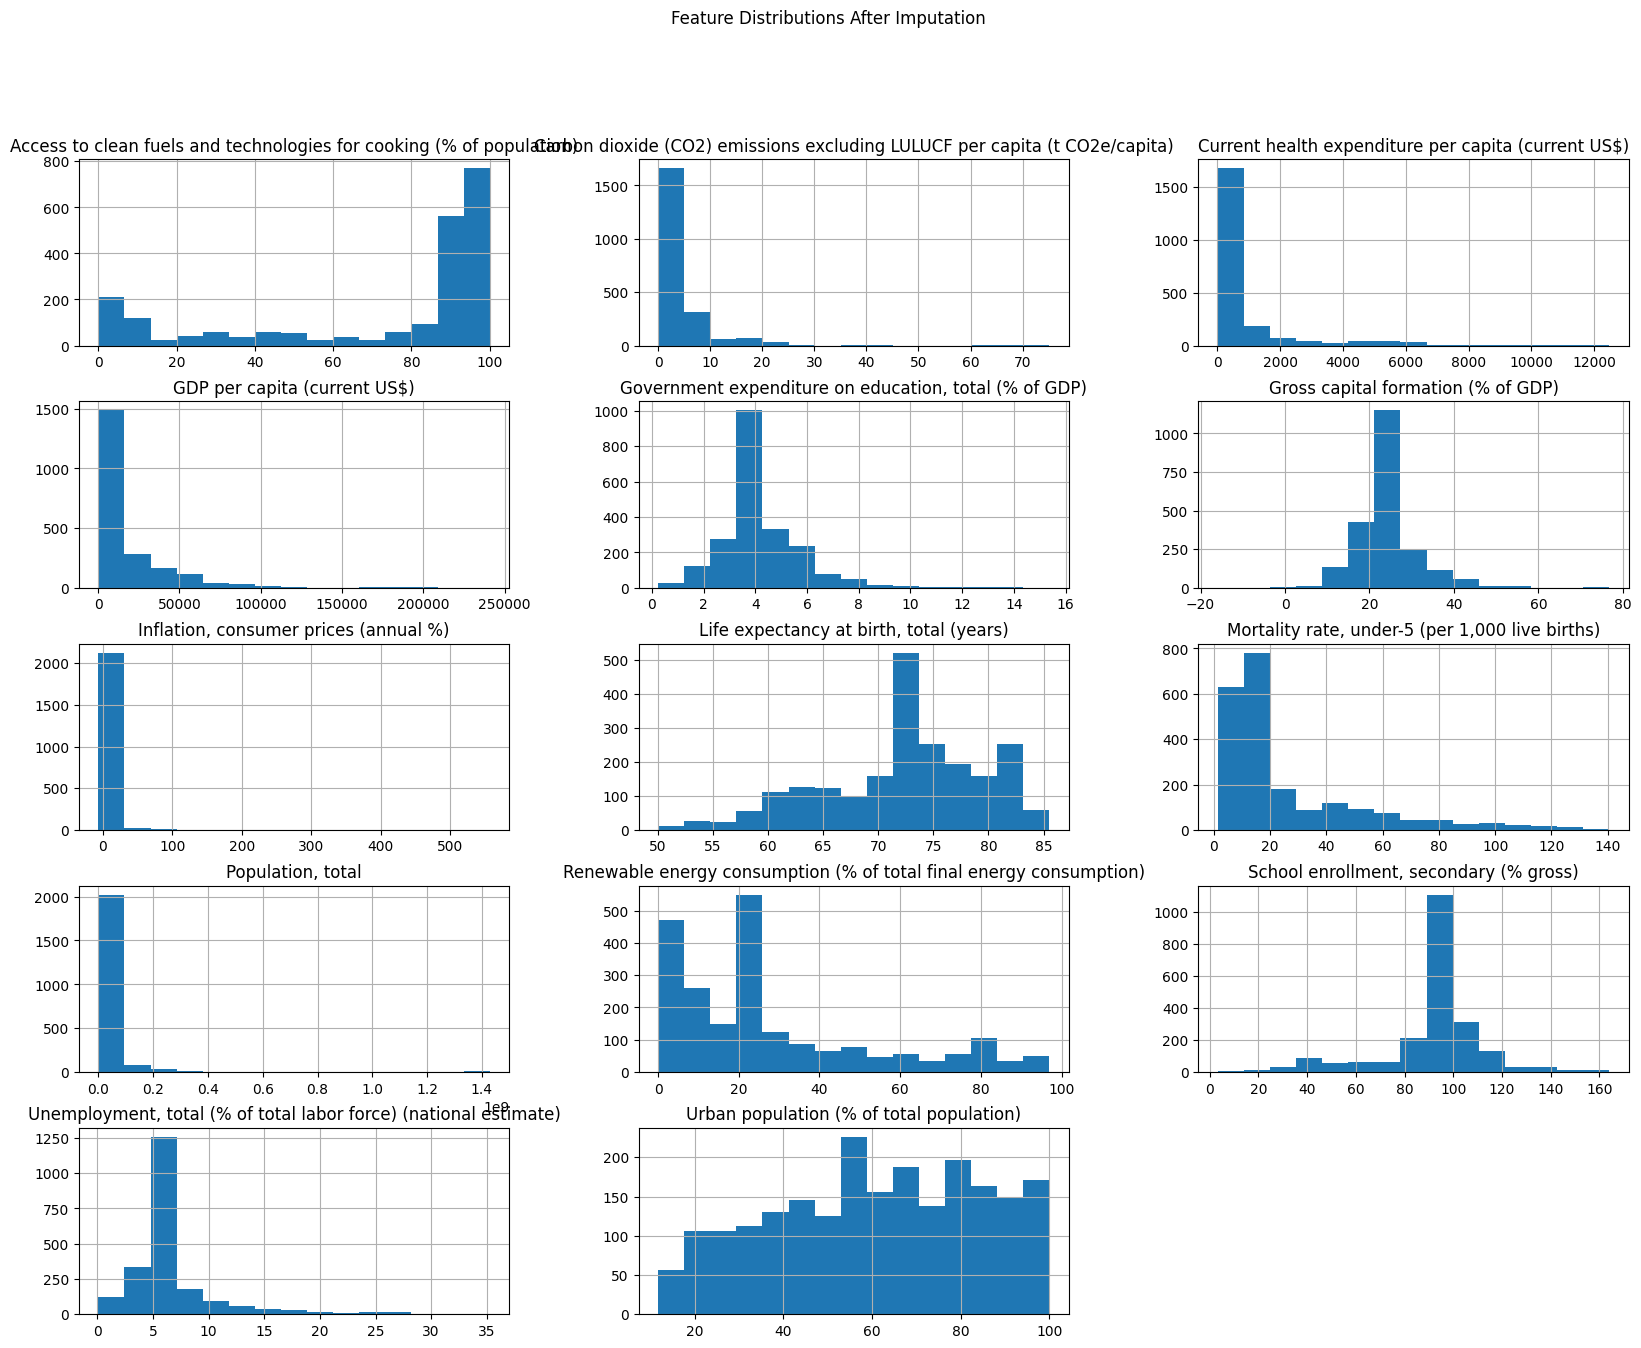

In [ ]:
# Create histograms for each feature to check data distribution
data_wide.iloc[:, 3:].hist(bins=15, figsize=(20, 15), layout=(5, 3))
plt.suptitle("Feature Distributions After Imputation")
plt.show()

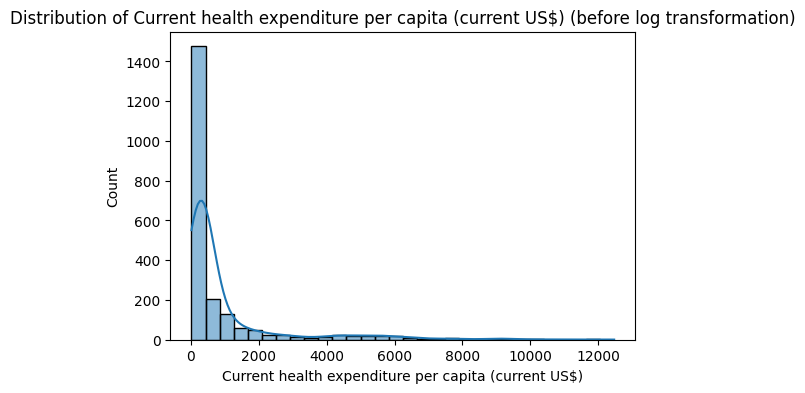

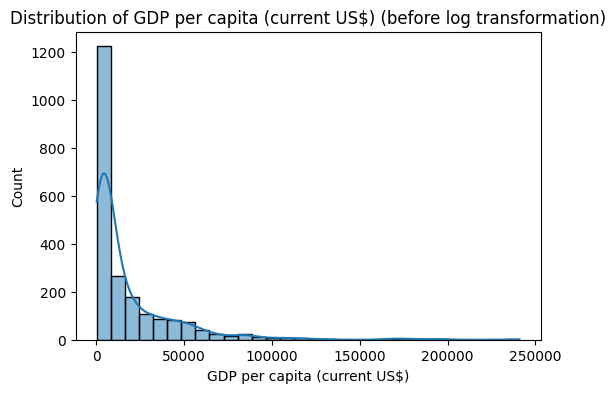

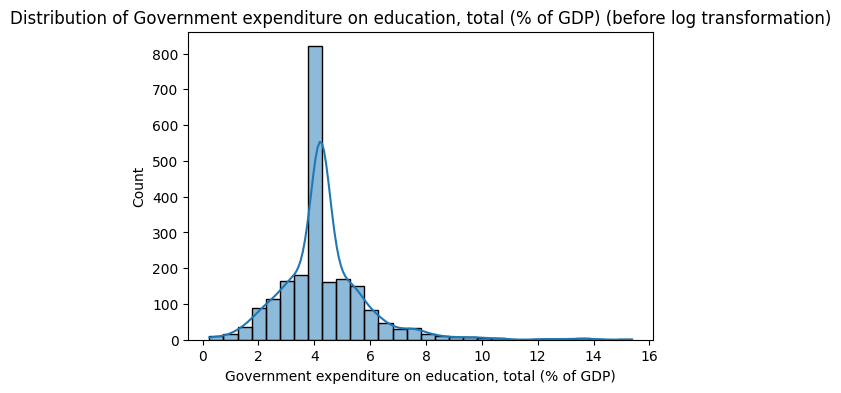

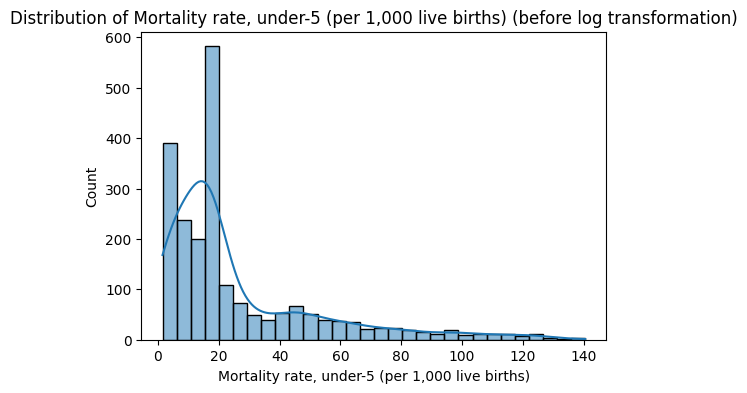

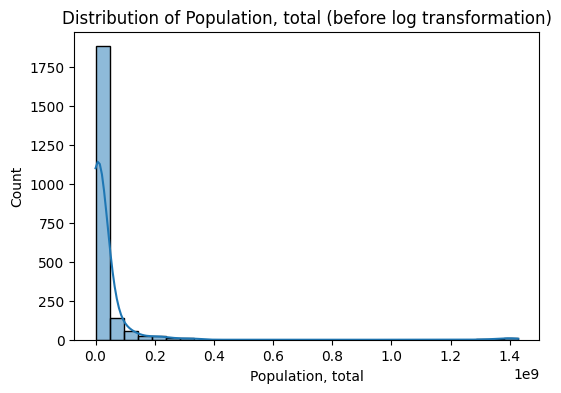

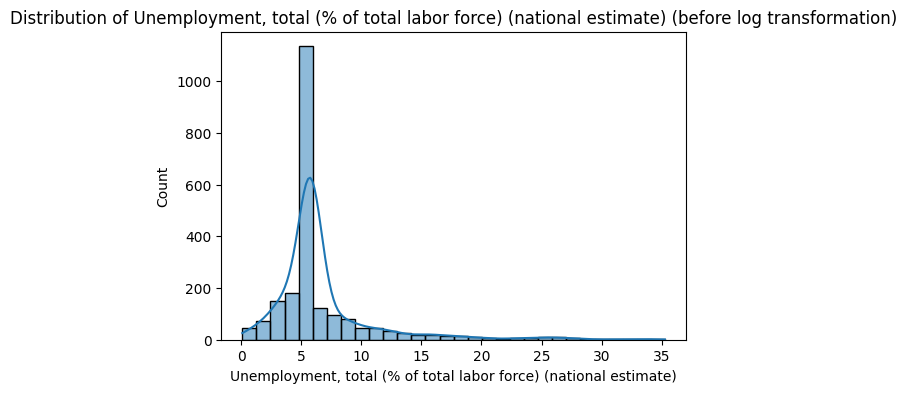

In [ ]:
# Check skewness for each numeric column
skewed_features = [col for col in numeric_columns if data_wide[col].skew() > 1 and data_wide[col].min() > 0]

for col in skewed_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data_wide[col], bins=30, kde=True)
    plt.title(f"Distribution of {col} (before log transformation)")
    plt.show()

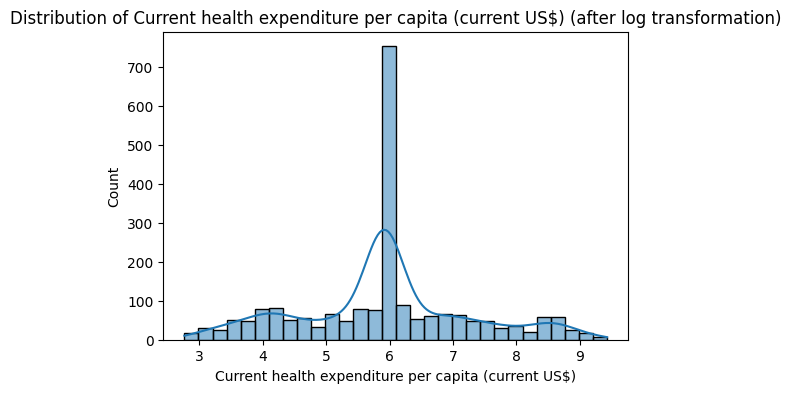

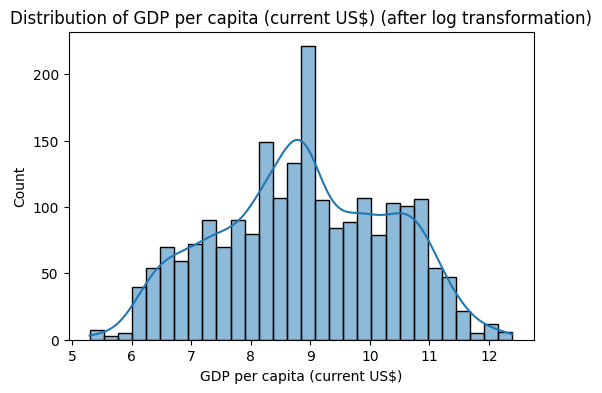

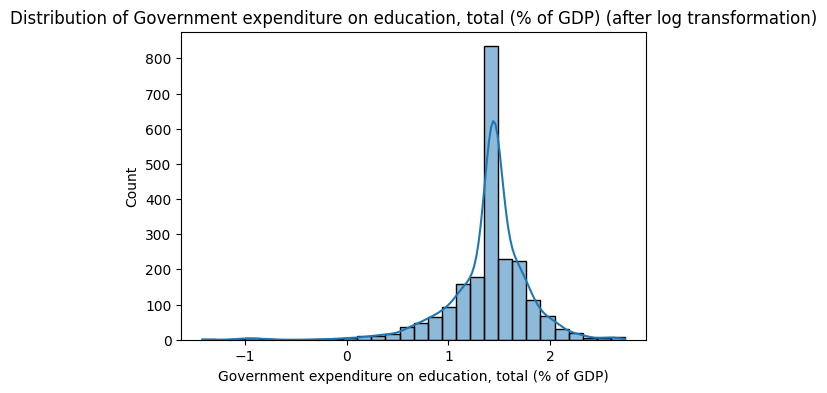

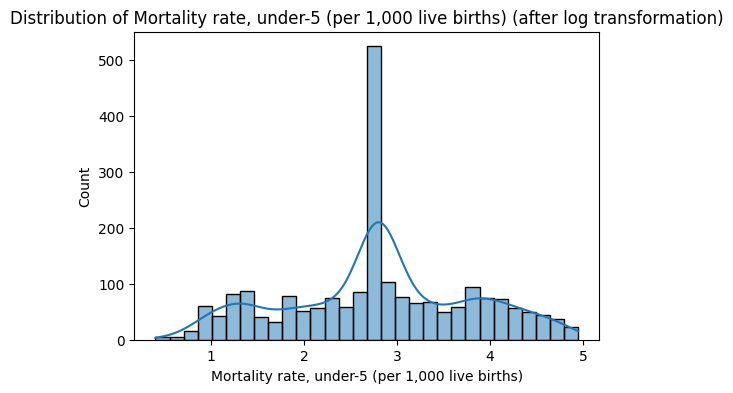

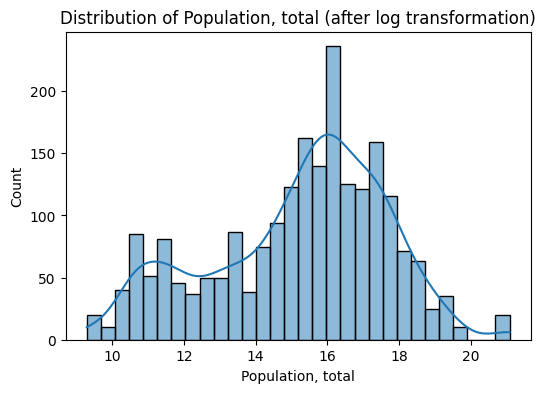

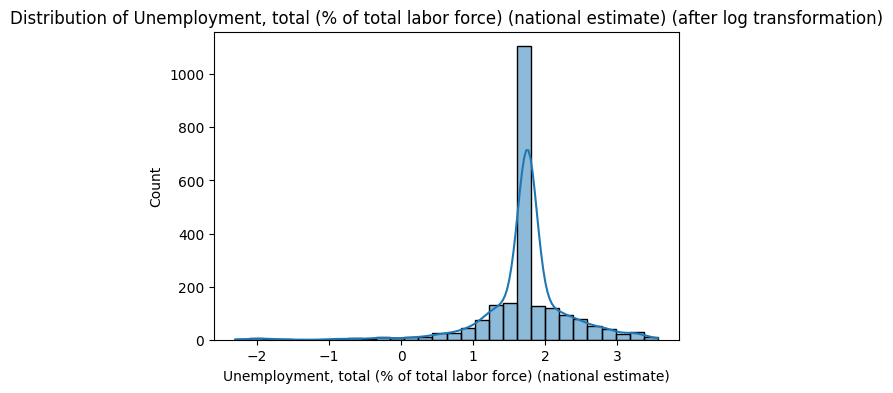

In [ ]:
for col in skewed_features:
    data_wide[col] = np.log(data_wide[col])

# Visualize distributions after log transformation
for col in skewed_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data_wide[col], bins=30, kde=True)
    plt.title(f"Distribution of {col} (after log transformation)")
    plt.show()

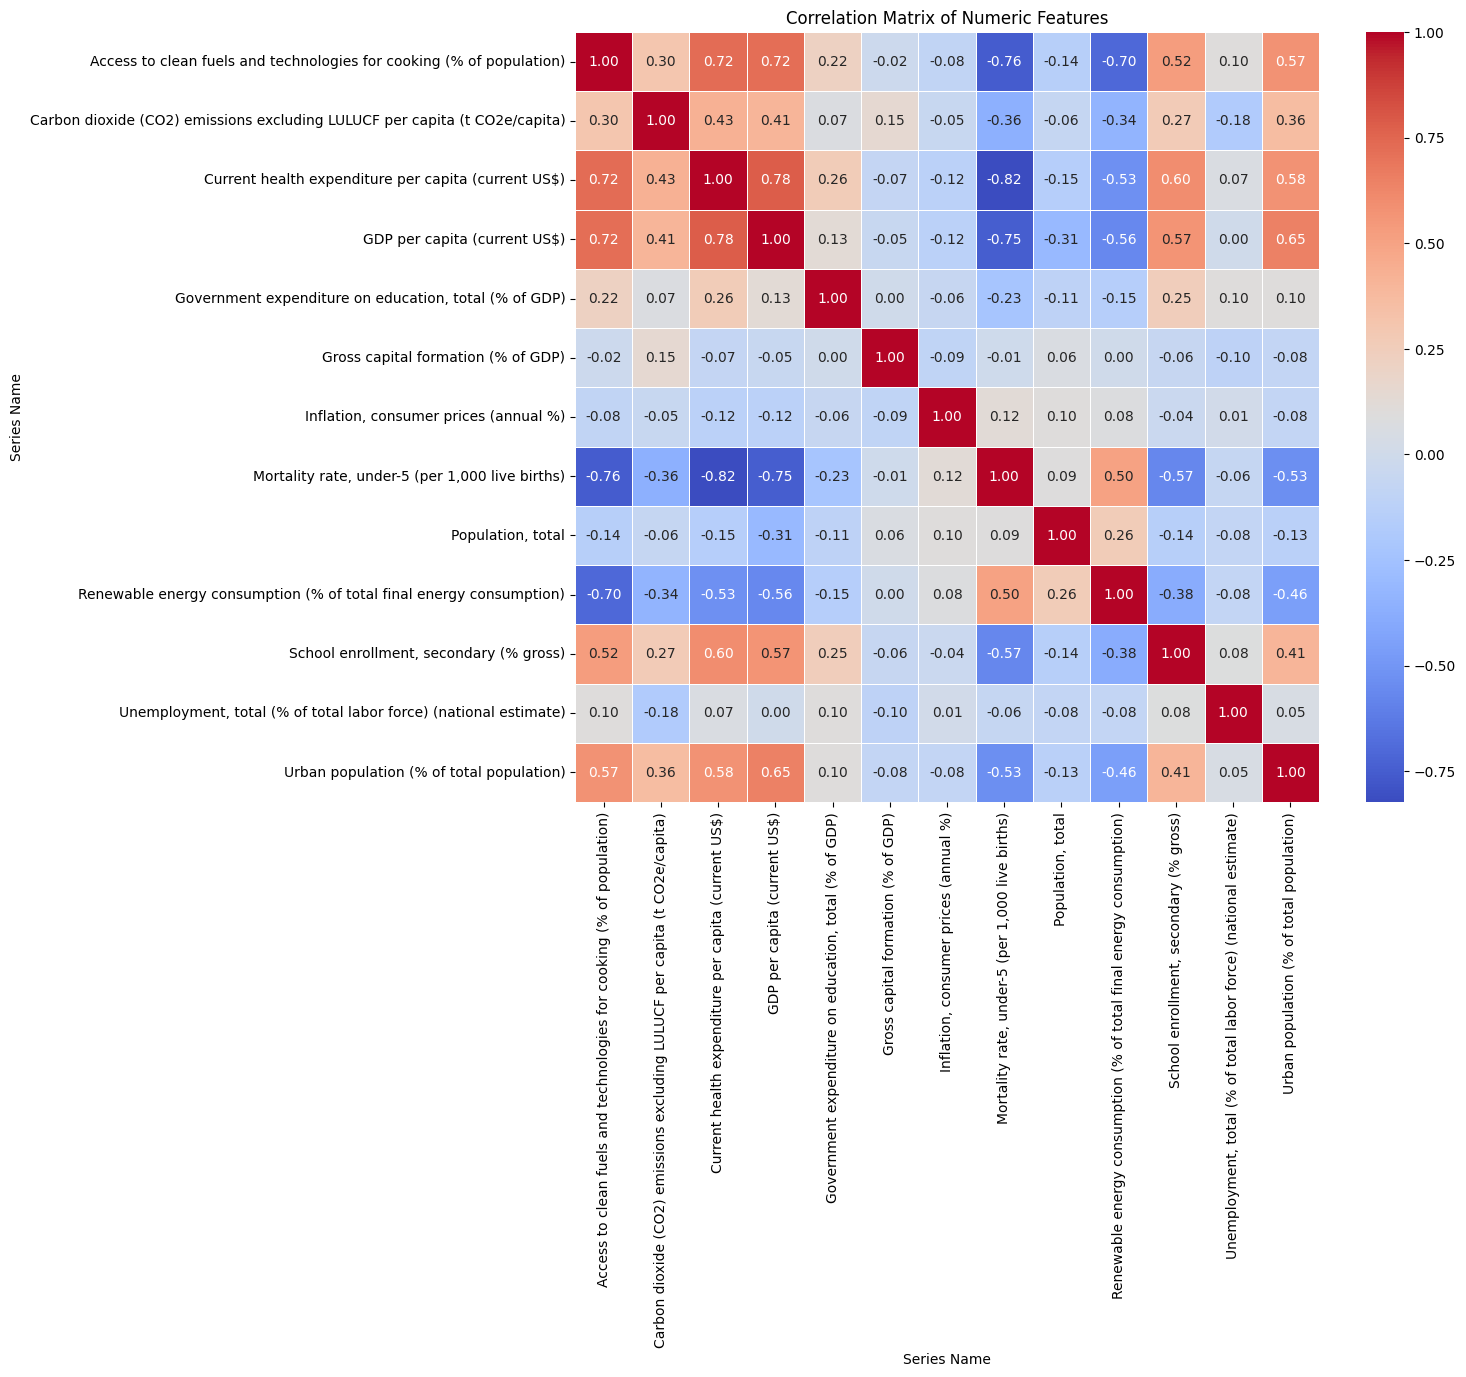

In [ ]:
# Exclude the 'year' column from numeric_columns
numeric_columns_no_year = [col for col in numeric_columns if 'year' not in col.lower()]

# Calculate the correlation matrix for numeric features excluding the 'year' column
correlation_matrix = data_wide[numeric_columns_no_year].corr()

# Plot the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [ ]:
# Drop the 'Year' column before aggregation
data_wide = data_wide.drop(columns=['Year'])

# Aggregate the data by Country (average over all years)
# Group by 'Country Name' and 'Country Code', and then calculate the mean of each numeric column
data_aggregated = data_wide.groupby(['Country Name', 'Country Code']).mean().reset_index()

# Check the resulting aggregated data
print("Aggregated dataset shape:", data_aggregated.shape)

Aggregated dataset shape: (217, 16)


In [ ]:
# Scale the numeric columns of the aggregated data
numeric_columns_aggregated = data_aggregated.select_dtypes(include=[np.number]).columns

# Standardize the numeric columns
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_aggregated[numeric_columns_aggregated])

Ideal number of dimensions to retain 95% variance: 5


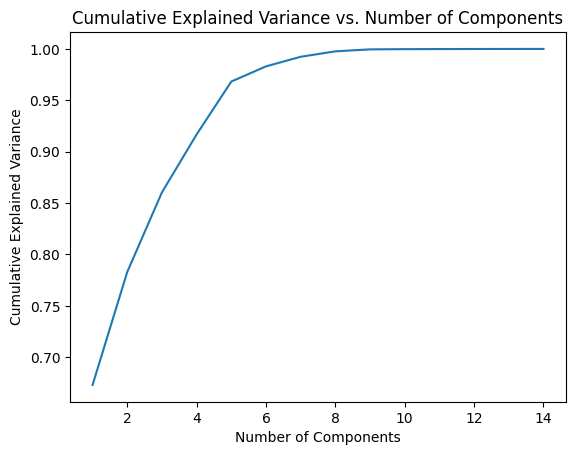

In [ ]:
# Select only numeric columns for PCA
numeric_data = data_aggregated.select_dtypes(include=[np.number])

# Fit PCA without reducing dimensions initially
pca = PCA().fit(numeric_data)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Determine the number of components to reach the desired variance of 95%
n_components = np.argmax(explained_variance >= 0.95) + 1
print(f"Ideal number of dimensions to retain 95% variance: {n_components}")

# Plot the explained variance
import matplotlib.pyplot as plt

plt.plot(range(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.show()

# **STEP 3: MODEL DESIGN & IMPLEMENTATION**
As previously noted, we reduced our numeric feature set to five principal components, capturing 95% of the data variance based on PCA analysis. Our goal during preprocessing was to simplify the dataset and retain only the most relevant information for clustering analysis.

We implemented four clustering techniques—K-Means, Hierarchical Clustering, Agglomerative Clustering, and Gaussian Mixture Models (GMM)—and compared each method’s performance across various cluster numbers and configurations. To evaluate each clustering approach, we used the silhouette score from sklearn, which measures clustering accuracy by comparing inter-cluster and intra-cluster distances, helping us determine the most effective number of clusters for our dataset.
<br><br>
**K-Means Clustering:** We calculated inertia across different values of k (from 1 to 10) and plotted each cluster to visualize the groupings. For each k, we also calculated the silhouette score to assess cluster quality.

**Hierarchical Clustering:** Using Ward’s linkage method, we constructed a hierarchical dendrogram and explored different clustering levels by cutting the dendrogram at various heights. The silhouette score was applied to these clusters to evaluate the performance.

**Agglomerative Clustering:** We applied agglomerative clustering with a specified cluster number of 2, comparing the results with those from K-Means and Hierarchical Clustering to check for potential performance improvements. Silhouette scoring was used to quantify clustering quality.

**Gaussian Mixture Models (GMM):** For GMM, we tested multiple cluster counts (from 2 to 10) and covariance types (full, tied, diag, and spherical), as well as different n_init values for optimal initialization. Each configuration was evaluated using the silhouette score to identify the best parameter combination.
<br><br>
Finally, we summarized the performance of each clustering method by visualizing the best-performing models for each algorithm, highlighting the separation achieved in the PCA-reduced space. This allowed us to determine the most effective clustering approach for our dataset based on silhouette score comparisons.


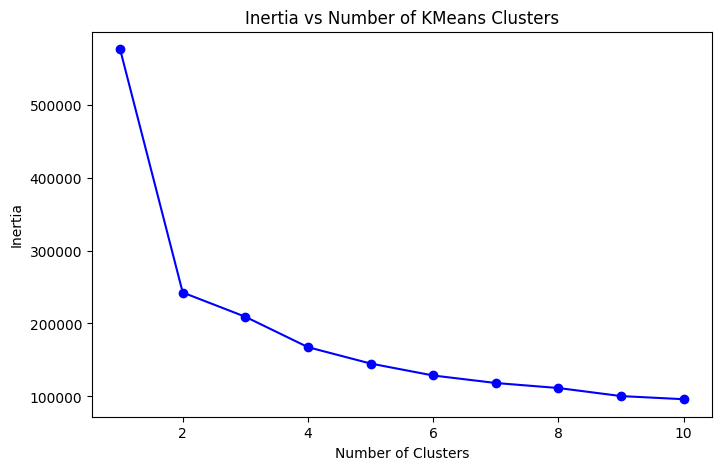

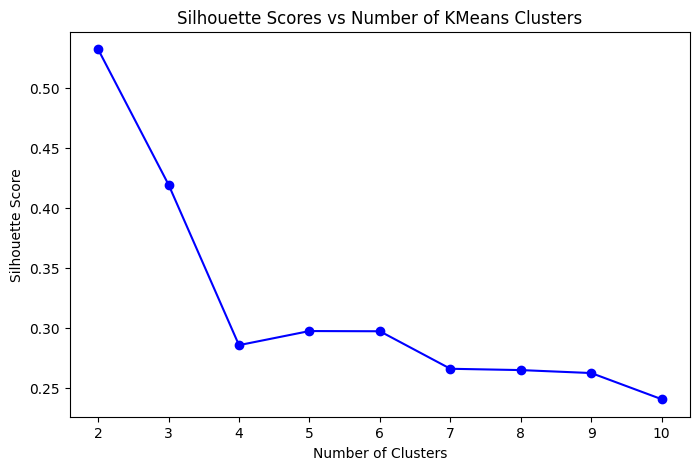

In [ ]:
# Reduce data to 5 principal components
pca = PCA(n_components=5)
data_reduced = pca.fit_transform(numeric_data)

# Convert reduced data back to a DataFrame for easier handling
data_reduced_df = pd.DataFrame(data_reduced, columns=[f'PC{i+1}' for i in range(5)])

# Calculate inertia for a range of clusters
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_reduced)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of KMeans Clusters')
plt.show()

# Calculate silhouette scores for each k value
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(data_reduced)
    score = silhouette_score(data_reduced, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores vs Number of KMeans Clusters')
plt.show()

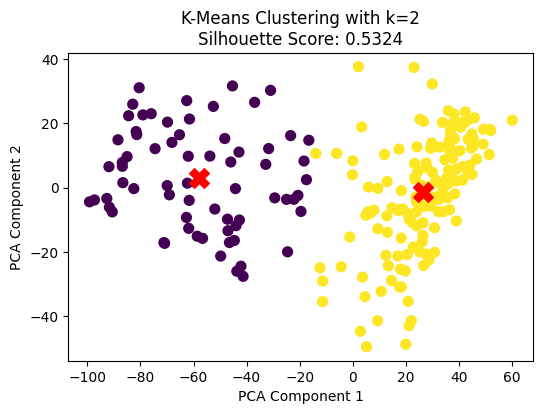

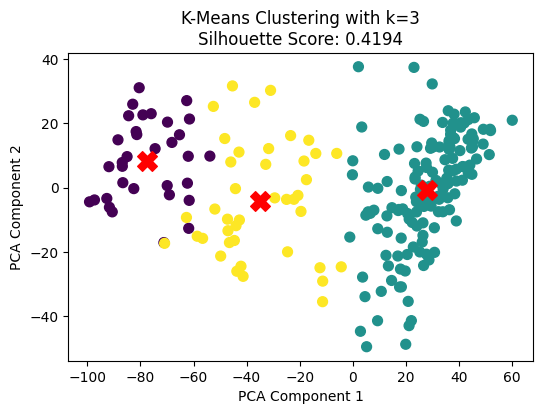

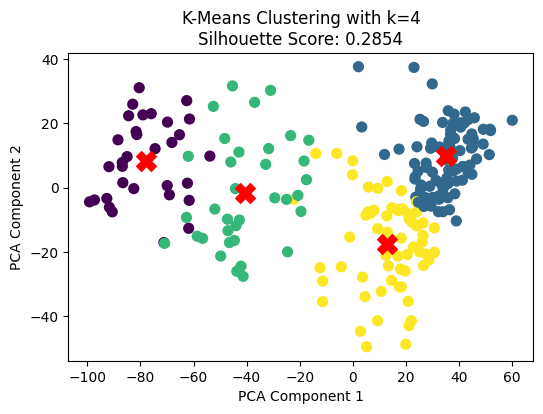

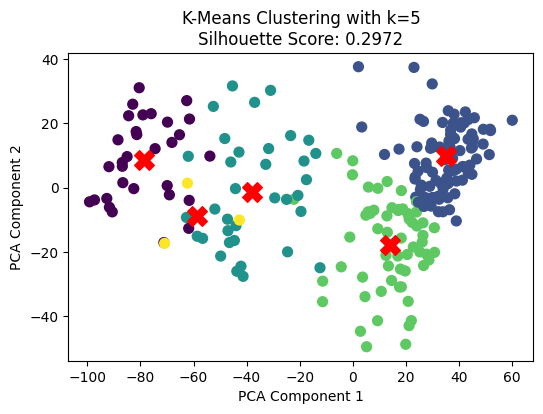

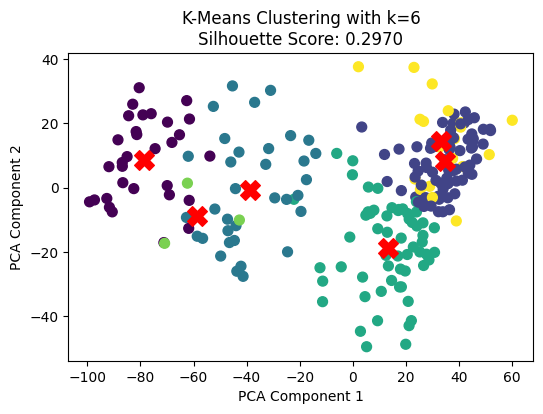

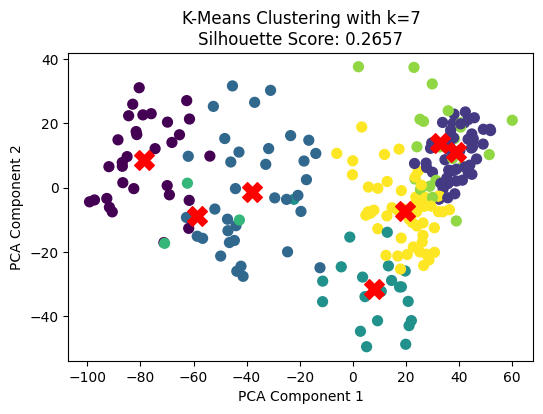

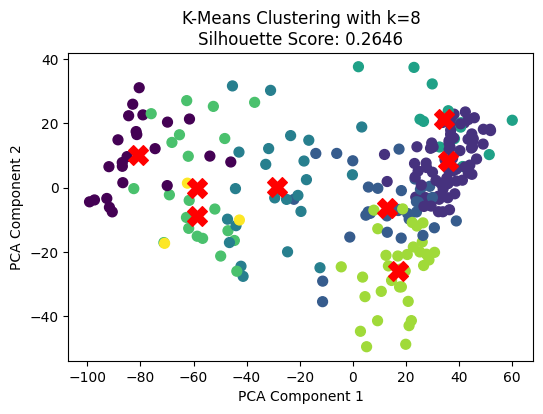

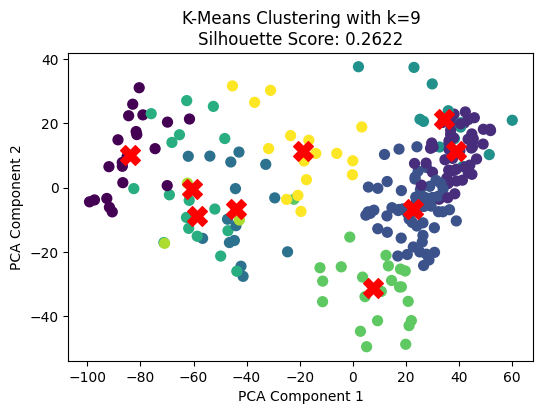

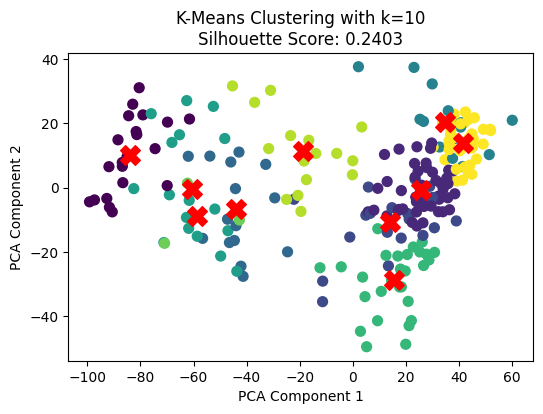

In [ ]:
# List to store silhouette scores for each k
silhouette_scores = []
cluster_range = range(2, 11)  # Trying k from 2 to 10 clusters

# Loop through different values of k and compute KMeans and silhouette score
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_reduced)

    # Calculate silhouette score
    score = silhouette_score(data_reduced, cluster_labels)
    silhouette_scores.append((k, score))

    # Plot the clusters for each k
    plt.figure(figsize=(6, 4))
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=cluster_labels, cmap='viridis', s=50)
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X')
    plt.title(f'K-Means Clustering with k={k}\nSilhouette Score: {score:.4f}')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()

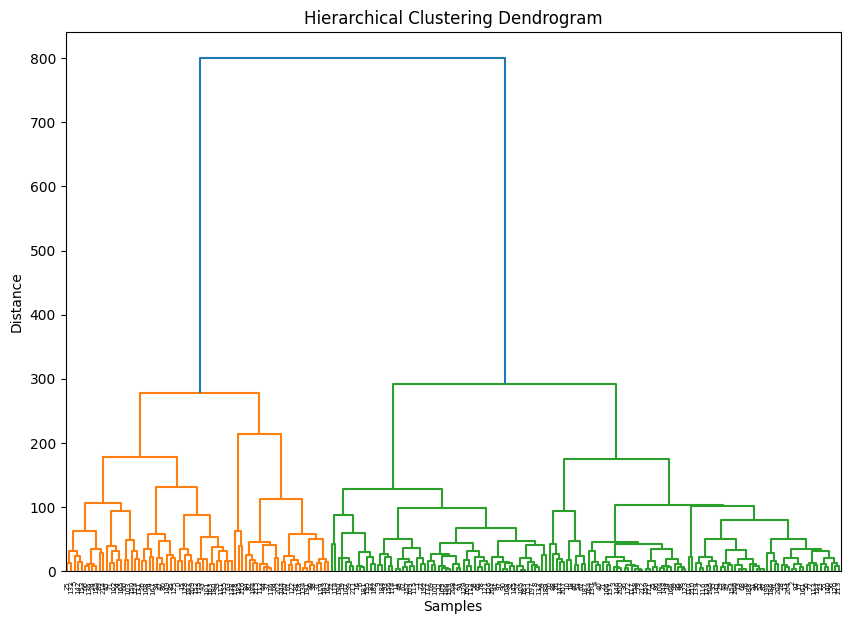

Silhouette Score for 2 clusters: 0.5054
Silhouette Score for 3 clusters: 0.3021
Silhouette Score for 4 clusters: 0.2740
Silhouette Score for 5 clusters: 0.2829
Silhouette Score for 6 clusters: 0.2858
Silhouette Score for 7 clusters: 0.2967
Silhouette Score for 8 clusters: 0.3028
Silhouette Score for 9 clusters: 0.2714
Silhouette Score for 10 clusters: 0.2709


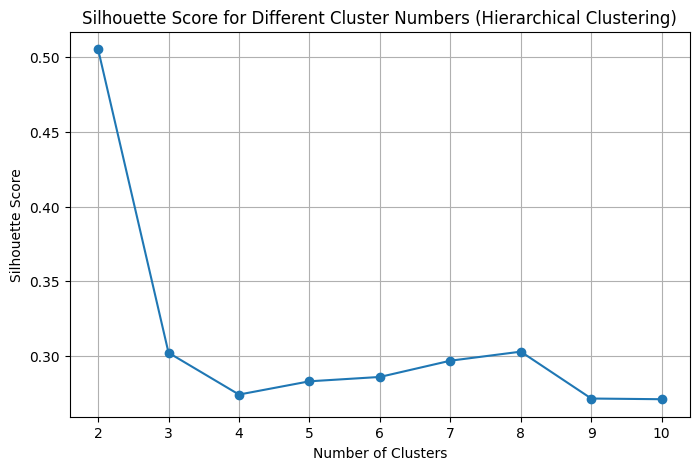

In [ ]:
# Perform hierarchical clustering with 'ward' linkage
linkage_matrix = linkage(data_reduced, method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')
plt.show()

# Range of cluster numbers to evaluate
min_clusters = 2
max_clusters = 10
silhouette_scores_hierarch = []

# Loop through different numbers of clusters
for n_clusters in range(min_clusters, max_clusters + 1):
    # Generate cluster labels by cutting the dendrogram at different cluster levels
    hierarchical_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')

    # Calculate silhouette score
    if len(set(hierarchical_labels)) > 1:  # Ensure there is more than 1 cluster
        score = silhouette_score(data_reduced, hierarchical_labels)
        silhouette_scores_hierarch.append((n_clusters, score))
        print(f"Silhouette Score for {n_clusters} clusters: {score:.4f}")
    else:
        silhouette_scores_hierarch.append((n_clusters, None))  # Store None if only one cluster is found

# Plot the silhouette scores for each cluster number
cluster_numbers, scores = zip(*[(n, s) for n, s in silhouette_scores_hierarch if s is not None])

plt.figure(figsize=(8, 5))
plt.plot(cluster_numbers, scores, marker='o')
plt.title('Silhouette Score for Different Cluster Numbers (Hierarchical Clustering)')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)
plt.show()

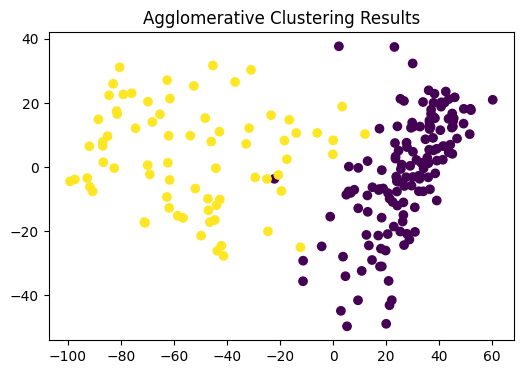

Silhouette Score for Agglomerative Clustering: 0.2709


In [ ]:
# Apply Agglomerative Clustering with specified number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=2)
agg_labels = agg_clustering.fit_predict(data_reduced)

# Visualize the clusters
plt.figure(figsize=(6, 4))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=agg_labels, cmap='viridis', marker='o')
plt.title('Agglomerative Clustering Results')
plt.show()

# Calculate silhouette score
if len(set(agg_labels)) > 1:
    silhouette_scores_agglomerative = silhouette_score(data_reduced, agg_labels)
    print(f"Silhouette Score for Agglomerative Clustering: {score:.4f}")
else:
    print("Agglomerative Clustering resulted in only one cluster (no silhouette score).")

In [ ]:
# Use a range of clusters and Gaussian Mixture hyperparameters
n_clusters_range = range(2, 11)  # Try clusters from 2 to 10
covariance_types = ['full', 'tied', 'diag', 'spherical']
n_init_values = [10, 20, 30]

# Store silhouette scores
silhouette_scores_gmm = []

# Iterate through combinations
for n_clusters in n_clusters_range:
    for covariance_type in covariance_types:
        for n_init in n_init_values:
            gmm = GaussianMixture(n_components=n_clusters, covariance_type=covariance_type, n_init=n_init)
            gmm_labels = gmm.fit_predict(data_reduced)
            if len(set(gmm_labels)) > 1:
                score = silhouette_score(data_reduced, gmm_labels)
                silhouette_scores_gmm.append((n_clusters, covariance_type, n_init, score))
            else:
                silhouette_scores_gmm.append((n_clusters, covariance_type, n_init, None))

# Print out results
for result in silhouette_scores_gmm:
    print(f"Clusters: {result[0]}, Covariance: {result[1]}, n_init: {result[2]} - Silhouette Score: {result[3]}")

Clusters: 2, Covariance: full, n_init: 10 - Silhouette Score: 0.4348502257761445
Clusters: 2, Covariance: full, n_init: 20 - Silhouette Score: 0.4348502257761445
Clusters: 2, Covariance: full, n_init: 30 - Silhouette Score: 0.4348502257761445
Clusters: 2, Covariance: tied, n_init: 10 - Silhouette Score: 0.5229248492952603
Clusters: 2, Covariance: tied, n_init: 20 - Silhouette Score: 0.5229248492952603
Clusters: 2, Covariance: tied, n_init: 30 - Silhouette Score: 0.5229248492952603
Clusters: 2, Covariance: diag, n_init: 10 - Silhouette Score: 0.43253560088769083
Clusters: 2, Covariance: diag, n_init: 20 - Silhouette Score: 0.43253560088769083
Clusters: 2, Covariance: diag, n_init: 30 - Silhouette Score: 0.43253560088769083
Clusters: 2, Covariance: spherical, n_init: 10 - Silhouette Score: 0.5210017862379989
Clusters: 2, Covariance: spherical, n_init: 20 - Silhouette Score: 0.5210017862379989
Clusters: 2, Covariance: spherical, n_init: 30 - Silhouette Score: 0.5210017862379989
Clusters: 

Best K-Means: k=2, Silhouette Score=0.5324


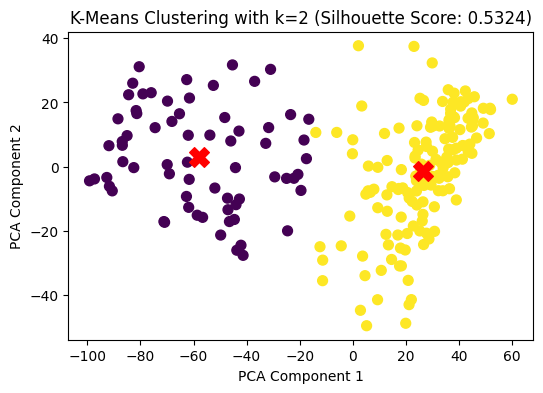

Best Hierarchical Clustering: n_clusters=2, Silhouette Score=0.5054


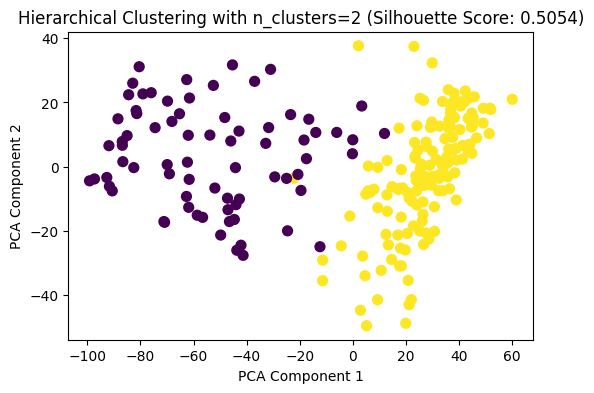

Agglomerative Clustering: Silhouette Score=0.5054


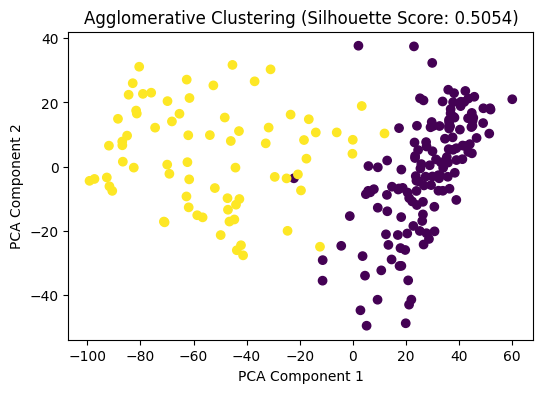

Best GMM: n_clusters=2, Covariance Type=tied, n_init=10, Silhouette Score=0.5229


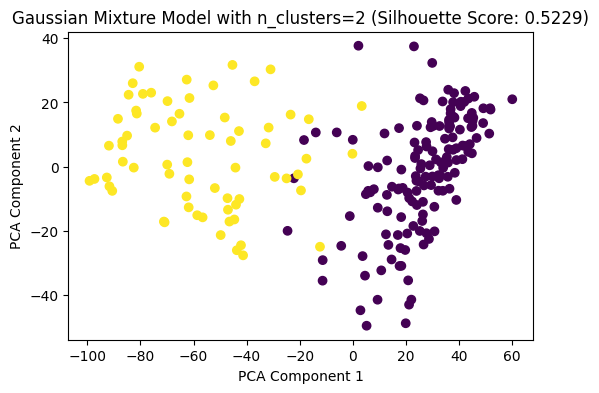

In [ ]:
# Best K-Means
best_kmeans = max(silhouette_scores, key=lambda x: x[1])  # (k, silhouette_score)
best_k = best_kmeans[0]
best_kmeans_score = best_kmeans[1]
print(f"Best K-Means: k={best_k}, Silhouette Score={best_kmeans_score:.4f}")

# Visualize K-Means with the best k
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans_labels = kmeans.fit_predict(data_reduced)
plt.figure(figsize=(6, 4))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=kmeans_labels, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title(f'K-Means Clustering with k={best_k} (Silhouette Score: {best_kmeans_score:.4f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Best Hierarchical Clustering
best_hierarchical = max(silhouette_scores_hierarch, key=lambda x: x[1])  # (n_clusters, silhouette_score)
best_hierarchical_k = best_hierarchical[0]
best_hierarchical_score = best_hierarchical[1]
print(f"Best Hierarchical Clustering: n_clusters={best_hierarchical_k}, Silhouette Score={best_hierarchical_score:.4f}")

# Visualize Hierarchical Clustering with the best n_clusters
hierarchical_labels = fcluster(linkage_matrix, best_hierarchical_k, criterion='maxclust')
plt.figure(figsize=(6, 4))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=hierarchical_labels, cmap='viridis', s=50)
plt.title(f'Hierarchical Clustering with n_clusters={best_hierarchical_k} (Silhouette Score: {best_hierarchical_score:.4f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Agglomerative Clustering with n_clusters=2
agg_clustering = AgglomerativeClustering(n_clusters=2)
agg_labels = agg_clustering.fit_predict(data_reduced)
agg_silhouette_score = silhouette_score(data_reduced, agg_labels)
print(f"Agglomerative Clustering: Silhouette Score={agg_silhouette_score:.4f}")

# Visualize Agglomerative Clustering
plt.figure(figsize=(6, 4))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=agg_labels, cmap='viridis', marker='o')
plt.title(f'Agglomerative Clustering (Silhouette Score: {agg_silhouette_score:.4f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Best Gaussian Mixture (GMM)
best_gmm = max(silhouette_scores_gmm, key=lambda x: x[3])  # (n_clusters, covariance_type, n_init, silhouette_score)
best_gmm_clusters = best_gmm[0]
best_gmm_covariance = best_gmm[1]
best_gmm_n_init = best_gmm[2]
best_gmm_score = best_gmm[3]
print(f"Best GMM: n_clusters={best_gmm_clusters}, Covariance Type={best_gmm_covariance}, n_init={best_gmm_n_init}, Silhouette Score={best_gmm_score:.4f}")

# Visualize GMM with the best parameters
gmm = GaussianMixture(n_components=best_gmm_clusters, covariance_type=best_gmm_covariance, n_init=best_gmm_n_init)
gmm_labels = gmm.fit_predict(data_reduced)
plt.figure(figsize=(6, 4))
plt.scatter(data_reduced[:, 0], data_reduced[:, 1], c=gmm_labels, cmap='viridis', marker='o')
plt.title(f'Gaussian Mixture Model with n_clusters={best_gmm_clusters} (Silhouette Score: {best_gmm_score:.4f})')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [ ]:
# Assign the cluster labels to the aggregated data
data_aggregated['Cluster'] = kmeans.labels_

# Calculate the mean of the original features for each cluster
cluster_means = data_aggregated.groupby('Cluster')[numeric_columns_aggregated].mean()

# Prepare a list of dictionaries with cluster information
cluster_summary = [
    {
        'Cluster': cluster_num,
        'Example Countries': ', '.join(data_aggregated[data_aggregated['Cluster'] == cluster_num]['Country Name'].sample(1).tolist()),
        **cluster_means.loc[cluster_num].to_dict()  # Add the mean values of original features
    }
    for cluster_num in range(best_k)
]

# Convert to DataFrame and round numeric columns to 2 decimal places
cluster_summary_df = pd.DataFrame(cluster_summary).round(2)

# Transpose the cluster summary to get features as rows instead of columns
cluster_summary_vertical = (
    cluster_summary_df.set_index('Cluster')
    .T.reset_index()  # Transpose and reset index to keep feature names
)

# Rename columns for clarity
cluster_summary_vertical.columns = ['Feature', 'Cluster 0', 'Cluster 1']

# Display the cluster summary in a vertical format
print("\nCluster Profile Summary (Mean values for original features):")
display(cluster_summary_vertical)


# Display example countries by cluster in a formatted way
print("\nExample Countries by Cluster:")
for cluster_num in range(best_k):
    example_countries = data_aggregated[data_aggregated['Cluster'] == cluster_num]['Country Name'].sample(10).tolist()
    print(f"\nCluster {cluster_num}:")
    display(pd.DataFrame(example_countries, columns=['Country']))


Cluster Profile Summary (Mean values for original features):


,Feature,Cluster 0,Cluster 1
0,Example Countries,Papua New Guinea,Saudi Arabia
1,Access to clean fuels and technologies for coo...,27.32,91.55
2,Carbon dioxide (CO2) emissions excluding LULUC...,0.95,5.8
3,Current health expenditure per capita (current...,4.63,6.51
4,GDP per capita (current US$),7.36,9.58
5,"Government expenditure on education, total (% ...",1.29,1.45
6,Gross capital formation (% of GDP),24.22,23.87
7,"Inflation, consumer prices (annual %)",9.59,4.36
8,"Life expectancy at birth, total (years)",65.09,75.82
9,"Mortality rate, under-5 (per 1,000 live births)",3.78,2.36



Example Countries by Cluster:

Cluster 0:


,Country
0,Bosnia and Herzegovina
1,Kiribati
2,"Gambia, The"
3,Haiti
4,Senegal
5,Guatemala
6,Comoros
7,Liberia
8,Honduras
9,Mauritania



Cluster 1:


,Country
0,Andorra
1,Germany
2,Dominican Republic
3,French Polynesia
4,"Egypt, Arab Rep."
5,Kuwait
6,Georgia
7,Canada
8,Iraq
9,Italy


# **STEP 4: RESULTS & ANALYSIS**
Using silhouette scores as our primary evaluation metric, we identified the optimal configurations for each clustering algorithm, revealing two distinct clusters that represent unique socio-economic, demographic, and environmental patterns across countries. Below is a summary of the results for each algorithm:
<br><br>
**K-Means:** Number of Clusters = 2, Silhouette Score = 0.5324

**Hierarchical Clustering:** Number of Clusters = 2, Silhouette Score = 0.5054

**Agglomerative Clustering:** Number of Clusters = 2, Silhouette Score = 0.5054

**Gaussian Mixture Model (GMM):** Number of Clusters = 2, Covariance Type = tied, Number of Init = 10, Silhouette Score = 0.5229
<br><br>
While all algorithms performed similarly, K-Means yielded the highest silhouette score, indicating slightly better-defined clusters compared to the other methods. Notably, adding a third cluster in each method resulted in a significant drop in silhouette scores, reinforcing the appropriateness of two clusters for this dataset.

These findings are influenced by our feature selection, dimensionality reduction via Principal Component Analysis, and choice of silhouette score as the evaluation metric. Although silhouette score served as our main metric, alternative metrics—such as the Davies-Bouldin Index, Adjusted Rand Index, or Calinski-Harabasz Index—could provide additional insights and potentially lead to different conclusions. Given the complexity of global socio-economic data, further analysis with other clustering configurations may be warranted.
<br><br>
### **Cluster Characteristics**
To gain insights into each cluster, we mapped cluster labels back to the original feature space, observing average feature values and identifying representative countries in each group.
<br><br>
**Cluster 0:** Countries in this cluster typically have lower access to clean cooking fuels (27.32%) and CO₂ emissions per capita (0.95 t CO2e/capita). They tend to rely more on renewable energy (52.23%) and have lower urban population percentages (39.73%). Socio-economic indicators, including health expenditure per capita ($4.63) and life expectancy (65.09 years), are also generally lower in Cluster 0.

**Cluster 1:** In contrast, countries in Cluster 1 have higher socio-economic indicators, with greater access to clean fuels (91.55%), higher CO₂ emissions per capita (5.80 t CO2e/capita), and longer life expectancy (75.82 years). These countries tend to be more urbanized (70.68%) and show lower reliance on renewable energy (15.85%).
<br><br>
Representative countries in each cluster further illustrate these groupings:

**Cluster 0:** Bosnia and Herzegovina, Kiribati, The Gambia, Haiti, Senegal, Guatemala, Comoros, Liberia, Honduras, Mauritania

**Cluster 1:** Andorra, Germany, Dominican Republic, French Polynesia, Arab Rep of Egypt, Kuwait, Georgia, Canada, Iraq, Italy
<br><br>
Overall, this clustering analysis reveals substantial contrasts between the two clusters, particularly in resource access, environmental impact, and socio-economic health. Cluster 0 encompasses countries with lower economic indicators and greater reliance on renewable energy, typically with more rural populations. Cluster 1 represents more urbanized, economically advanced countries with higher emissions and access to amenities like clean cooking fuels. These insights could guide policymakers in tailoring strategies based on each group’s unique characteristics, enabling more targeted and effective interventions.


# **STEP 5: CONCLUSION**
In this project, we applied unsupervised learning techniques to cluster countries based on socio-economic, demographic, and environmental factors. Using the selected indicators and dimensionality reduction, our analysis found that clustering world countries into two groups yielded the highest performance across the models tested. Each of these clusters reveals distinct contrasts in access to resources, environmental conditions, and quality-of-life indicators.

Our primary evaluation metric, the Silhouette Score, showed similar results across the various clustering algorithms, with K-Means Clustering slightly outperforming the others. Mapping the average values for each cluster back to the original indicators allowed us to observe the following patterns:
<br><br>
**Cluster 0:** Comprised of countries with lower economic indicators, greater reliance on renewable energy, and more rural populations.

**Cluster 1:** Characterized by higher urbanization levels, greater access to modern amenities, and higher emissions per capita, reflecting an overall higher socio-economic standing.
<br><br>
These insights highlight the potential of unsupervised learning to reveal underlying structures within complex datasets, such as the diverse aspects of global development. Future work could focus on incorporating additional features, alternative metrics, or exploring more granular clustering to capture subtler variations across countries. Ultimately, the results of this analysis provide a valuable tool for policymakers, enabling more targeted and effective interventions to address each cluster’s specific needs and challenges.




---



The World Bank. (n.d.). World development indicators. Retrieved November 9, 2024, from https://databank.worldbank.org/source/world-development-indicators

scikit-learn developers. (n.d.). sklearn.decomposition.PCA. scikit-learn. Retrieved November 10, 2024, from https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.PCA.html

scikit-learn developers. (n.d.). sklearn.metrics.silhouette_score. scikit-learn. Retrieved November 10, 2024, from https://scikit-learn.org/dev/modules/generated/sklearn.metrics.silhouette_score.html

scikit-learn developers. (n.d.). sklearn.cluster.KMeans. scikit-learn. Retrieved November 11, 2024, from https://scikit-learn.org/dev/modules/generated/sklearn.cluster.KMeans.html

scikit-learn developers. (n.d.). Gaussian mixture models. scikit-learn. Retrieved November 11, 2024, from https://scikit-learn.org/1.5/modules/mixture.html

GeeksforGeeks. (n.d.). Clustering metrics. Retrieved November 11, 2024, from https://www.geeksforgeeks.org/clustering-metrics/

GeeksforGeeks. (n.d.). Hierarchical clustering with scikit-learn. Retrieved November 10, 2024, from https://www.geeksforgeeks.org/hierarchical-clustering-with-scikit-learn/